# Introduction
In this tutorial, we give an end-to-end demo of compressing [MobileNetV2](https://arxiv.org/abs/1801.04381) for finegrained classification using [NNI Pruners](https://nni.readthedocs.io/en/stable/Compression/pruning.html). Although MobileNetV2 is already a highly optimized architecture, we show that we can further reduce its size by over 50% with minimal performance loss using iterative pruning and knowledge distillation. To similate a real usage scenario, we use the [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/) dataset as the target task, and show how to implement and optimize the following steps:
* Model pre-training
* Pruning
* Model Speedup
* Finetuning the pruned model

Also, we will compare our approach with some baseline channel compression schemes defined by the authors of the MobileNets, and show that NNI pruners can provide a superior performance while being easy-to-use. We release this notebook along with our code under the folder `examples/model_compress/pruning/mobilenet_end2end/`.
<div>
<img src="final_performance.png" width="750"/>
</div>

In [1]:
import os
import xml
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from nni.compression.pytorch import ModelSpeedup
from nni.compression.pytorch.utils.counter import count_flops_params

from utils import create_model, get_dataloader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_workers = 16
torch.set_num_threads(num_workers)

# Background
### Pruning MobileNetV2
The main building block of MobileNetV2 is "inverted residual blocks", where a pointwise convolution first projects into a feature map with higher channels,following a depthwise convolution, and a pointwise convolution with linear activation that projects into a features map with less channels (thus called "inverted residuals and linear bottlenecks"). With 11 such blocks stacked together, the entire model has 3.4M parameters and takes up about 10M storage space (this number is platform-dependent).

<div>
<img src="mobilenet.png" width="300"/>
</div>

Now we consider compressing MobileNetV2 by **filter pruning** (also called channel pruning). Recall that in genernal, a $k\times k$ convolutional kernel has the weight with shape $(out\_channel, \frac{in\_channel}{groups}, k, k)$. If the input has shape $(B, in\_channel, H, W)$, the convolutional layer's output (with padding) would have shape $(B, out\_channel, H, W)$. Suppose we remove $M$ filters from this layer, then weight would have shape $(out\_channel-M, \frac{in\_channel}{groups}, k, k)$, and the output would then have shape $(B, out\_channel - M, H, W)$. Further, we have the following observations:
* The model's number of parameters is directly reduced by $M\times \frac{in\_channel}{groups} \times k \times k$.
* We are performing structured pruning, as each filter's weight elements are adjacent. Compared to unstructured pruning (or fine-grained pruning), structured pruning generally allows us to directly remove weights and their connections from the network, resulting in greater compression and speed-up. For this reason, in this tutorial we solely focus on filter-level pruning. 
* Since the output channel is shrinked, we can also remove weights from the next layer corresponding to these channel dimensions. In NNI, the pruner prunes the weights by just setting the weight values to zero, and then the [ModelSpeedup](https://nni.readthedocs.io/en/stable/Compression/ModelSpeedup.html) tool infers the weight relations and removes pruned weights and connections, which we will also demonstrate later.

In [2]:
# check model architecture
model = torch.hub.load('pytorch/vision:v0.8.1', 'mobilenet_v2', pretrained=True).to(device)
print(model)

# check model FLOPs and parameter counts with NNI utils
dummy_input = torch.rand([1, 3, 224, 224]).to(device)
flops, params, results = count_flops_params(model, dummy_input)
print(f"FLOPs: {flops}, params: {params}")

Using cache found in /home/v-diwu4/.cache/torch/hub/pytorch_vision_v0.8.1


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

)
+-------+----------------------+--------+-------------------+----------+---------+
| Index |         Name         |  Type  |    Weight Shape   |  FLOPs   | #Params |
+-------+----------------------+--------+-------------------+----------+---------+
|   0   |     features.0.0     | Conv2d |   (32, 3, 3, 3)   | 10838016 |   864   |
|   1   | features.1.conv.0.0  | Conv2d |   (32, 1, 3, 3)   | 3612672  |   288   |
|   2   |  features.1.conv.1   | Conv2d |   (16, 32, 1, 1)  | 6422528  |   512   |
|   3   | features.2.conv.0.0  | Conv2d |   (96, 16, 1, 1)  | 19267584 |   1536  |
|   4   | features.2.conv.1.0  | Conv2d |   (96, 1, 3, 3)   | 2709504  |   864   |
|   5   |  features.2.conv.2   | Conv2d |   (24, 96, 1, 1)  | 7225344  |   2304  |
|   6   | features.3.conv.0.0  | Conv2d |  (144, 24, 1, 1)  | 10838016 |   3456  |
|   7   | features.3.conv.1.0  | Conv2d |   (144, 1, 3, 3)  | 4064256  |   1296  |
|   8   |  features.3.conv.2   | Conv2d |  (24, 144, 1, 1)  | 10838016 |   3456  |
| 

### Stanford Dogs

The [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/) dataset contains images of 120 breeds of dogs from around the world. It is built using images and annotation from ImageNet for the task of fine-grained image classification. We choose this task to simulate a transfer learning scenario, where a model pre-trained on the ImageNet is further transferred to an often simpler downstream task.

To download and prepare the data, please run `prepare_data.sh`, which downloads the images and annotations, and preprocesses the images for training. Then, you may run following code block, which shows several instances:

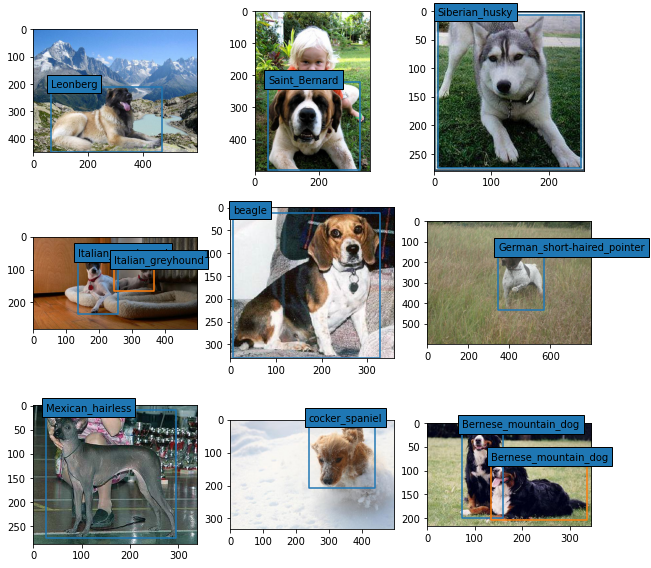

In [3]:
# Show several examples
# Code adapted from https://www.kaggle.com/mclikmb4/xception-transfer-learning-120-breeds-83-acc
image_path = './data/stanford-dogs/Images/'
breed_list = sorted(os.listdir(image_path))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i)
    breed = np.random.choice(breed_list)
    dog = np.random.choice(os.listdir('./data/stanford-dogs/Annotation/' + breed))
    img = Image.open(image_path + breed + '/' + dog + '.jpg') 
    tree = xml.etree.ElementTree.parse('./data/stanford-dogs/Annotation/' + breed + '/' + dog)
    root = tree.getroot()
    objects = root.findall('object')
    plt.imshow(img)
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None})


# Model Pre-training
First, we obtain a MobileNetV2 model on this task, which will serve as the base model for compression. Unfortunately, although this step is often called model "pre-training" in the model compression teminologies, we are actually finetuning a model pre-trained on ImageNet. 

In [4]:
# This script will save the state dict of the pretrained model to "./pretrained_mobilenet_v2_torchhub/checkpoint_best.pt"

# %run pretrain.py
# %run test.py

# Compression via Pruning
In this section, we first demonstrate how to perform channel pruning with NNI pruners in three steps: 
* defining a config list
* creating a Pruner instance
* calling `pruner.compress` and `pruner.export_model` to calculate and export masks

Then, we demonstrate the common practices after pruning:
* model speedup
* further finetuning (with or without knowledge distillation)
* evaluation

Finally, we present a grid search example to find the balance between model performance and the final model size. We include some of our results and discuss our observations. 

Note that the code blocks in this section are taken from the file `pruning_experiments.py`. You can directly run the file by specifying several command line arguments and see the end-to-end process. You can also run the file to reproduce our experiments. We will discuss that in the last section. 

### Using NNI Pruners

In [5]:
from nni.algorithms.compression.pytorch.pruning import (
    LevelPruner,
    SlimPruner,
    FPGMPruner,
    TaylorFOWeightFilterPruner,
    L1FilterPruner,
    L2FilterPruner,
    AGPPruner,
    ActivationMeanRankFilterPruner,
    ActivationAPoZRankFilterPruner
)

pruner_name_to_class = {
    'level': LevelPruner,
    'l1': L1FilterPruner,
    'l2': L2FilterPruner,
    'slim': SlimPruner,
    'fpgm': FPGMPruner,
    'taylor': TaylorFOWeightFilterPruner,
    'agp': AGPPruner,
    'activationmeanrank': ActivationMeanRankFilterPruner,
    'apoz': ActivationAPoZRankFilterPruner
}


In [6]:
# load model from the pretrained checkpoint
model_type = 'mobilenet_v2_torchhub'
checkpoint = "./pretrained_mobilenet_v2_torchhub/checkpoint_best.pt"
pretrained = True 
input_size = 224
n_classes = 120

model = create_model(model_type=model_type, pretrained=pretrained, n_classes=n_classes,
                     input_size=input_size, checkpoint=checkpoint).to(device)

Using cache found in /home/v-diwu4/.cache/torch/hub/pytorch_vision_v0.8.1


In [7]:
# Defining the config list.
# Note that here we only prune the depthwise convolution and the last pointwise convolution. 
# We will let the model speedup tool propagate the sparsity to the first pointwise convolution layer. 

pruner_name = 'l1'
sparsity = 0.5

if pruner_name != 'slim':
    config_list = [{
        'op_names': ['features.{}.conv.1.0'.format(x) for x in range(2, 18)],
        'sparsity': sparsity
    },{
        'op_names': ['features.{}.conv.2'.format(x) for x in range(2, 18)],
        'sparsity': sparsity
    }]
else:
    # For slim pruner, we should specify BatchNorm layers instead of the corresponding Conv2d layers
    config_list = [{
        'op_names': ['features.{}.conv.1.1'.format(x) for x in range(2, 18)],
        'sparsity': sparsity
    },{
        'op_names': ['features.{}.conv.3'.format(x) for x in range(2, 18)],
        'sparsity': sparsity
    }]

# Different pruners require different additional parameters, so we put them together in the kwargs dict. 
# Please check the docs for detailed information.
kwargs = {}                                                                                                                                
if pruner_name in ['slim', 'taylor', 'activationmeanrank', 'apoz', 'agp']:
    from pruning_experiments import trainer_helper
    train_dataloader = get_dataloader('train', './data/stanford-dogs/Processed/train', batch_size=32)
    def trainer(model, optimizer, criterion, epoch):
        return trainer_helper(model, criterion, optimizer, train_dataloader, device)
    kwargs = {
        'trainer': trainer,
        'optimizer': torch.optim.Adam(model.parameters()),
        'criterion': nn.CrossEntropyLoss()
    }
    if pruner_name == 'agp':
        kwargs['pruning_algorithm'] = 'l1'
        kwargs['num_iterations'] = 10
        kwargs['epochs_per_iteration'] = 1
    if pruner_name == 'slim':
        kwargs['sparsifying_training_epochs'] = 10

# Create pruner, call pruner.compress(), and export the pruned model
pruner = pruner_name_to_class[pruner_name](model, config_list, **kwargs)
pruner.compress()
pruner.export_model('./pruned_model.pth', './mask.pth')

[2021-08-27 09:01:56] INFO (nni.compression.pytorch.compressor/MainThread) Model state_dict saved to ./pruned_model.pth
[2021-08-27 09:01:56] INFO (nni.compression.pytorch.compressor/MainThread) Mask dict saved to ./mask.pth


### Model Speedup

In [ ]:
# Note: must unwrap the model before speed up
pruner._unwrap_model()

dummy_input = torch.rand(1,3,224,224).to(device)
ms = ModelSpeedup(model, dummy_input, './mask.pth')
ms.speedup_model()

In [9]:
flops, params, results = count_flops_params(model, dummy_input)
print(model)
print(f"FLOPs: {flops}, params: {params}")

+-------+----------------------+--------+-------------------+----------+---------+
| Index |         Name         |  Type  |    Weight Shape   |  FLOPs   | #Params |
+-------+----------------------+--------+-------------------+----------+---------+
|   0   |     features.0.0     | Conv2d |   (32, 3, 3, 3)   | 10838016 |   864   |
|   1   | features.1.conv.0.0  | Conv2d |   (32, 1, 3, 3)   | 3612672  |   288   |
|   2   |  features.1.conv.1   | Conv2d |   (16, 32, 1, 1)  | 6422528  |   512   |
|   3   | features.2.conv.0.0  | Conv2d |   (48, 16, 1, 1)  | 9633792  |   768   |
|   4   | features.2.conv.1.0  | Conv2d |   (48, 1, 3, 3)   | 1354752  |   432   |
|   5   |  features.2.conv.2   | Conv2d |   (16, 48, 1, 1)  | 2408448  |   768   |
|   6   | features.3.conv.0.0  | Conv2d |   (72, 16, 1, 1)  | 3612672  |   1152  |
|   7   | features.3.conv.1.0  | Conv2d |   (72, 1, 3, 3)   | 2032128  |   648   |
|   8   |  features.3.conv.2   | Conv2d |   (16, 72, 1, 1)  | 3612672  |   1152  |
|   

)
FLOPs: 139206976, params: 1074880


### Fine-tuning after Pruning

Usually, after pruning out some weights from the model, we need further fine-tuning to let the model recover its performance as much as possible. For finetuning, we can either use the same setting during pretraining, or use an additional technique called [**Knowledge Distillation**](https://arxiv.org/pdf/1503.02531.pdf). The key idea is that the model learns on both the original hard labels and the soft labels produced by a teacher model running on the same input. In our setting, **the model before pruning can conveniently serve as the teacher model**. Empirically, we found that using distillation during fine-tuning consistently improves the performance of the pruned model. We will further discuss related experiments in the following section.

Note that knowledge distillation can easily be done with the following lines of code:

In [ ]:
# sample code: training with knowledge distillation
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

def train_with_distillation(student_model, teacher_model, optimizer, train_dataloader, device, alpha=0.99, temperature=8):
    student_model.train()
    for i, (inputs, labels) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        inputs, labels = inputs.float().to(device), labels.to(device)
        with torch.no_grad():
            teacher_preds = teacher_model(inputs)

        student_preds = student_model(inputs)
        soft_loss = nn.KLDivLoss()(F.log_softmax(student_preds/temperature, dim=1),
                                   F.softmax(teacher_preds/temperature, dim=1))
        hard_loss = F.cross_entropy(student_preds, labels)
        loss = soft_loss * (alpha * temperature * temperature) + hard_loss * (1. - alpha)

        loss.backward()
        optimizer.step()
'''

Finetuning after pruning:

In [11]:
from pruning_experiments import run_finetune, run_finetune_distillation, run_eval

use_distillation = True
n_epochs = 10                  # set for demo purposes; increase this number for your experiments
learning_rate = 1e-4
weight_decay = 0.0

train_dataloader = get_dataloader('train', './data/stanford-dogs/Processed/train', batch_size=32)
valid_dataloader = get_dataloader('eval', './data/stanford-dogs/Processed/valid', batch_size=32)
test_dataloader = get_dataloader('eval', './data/stanford-dogs/Processed/test', batch_size=32)

if not use_distillation:
    run_finetune(model, train_dataloader, valid_dataloader, device, 
                 n_epochs=n_epochs, learning_rate=learning_rate, weight_decay=weight_decay)
else:
    alpha = 0.99
    temperature = 8
    # use model with the original checkpoint as the teacher
    teacher_model = create_model(model_type=model_type, pretrained=pretrained, n_classes=n_classes,
                                 input_size=input_size, checkpoint=checkpoint).to(device)
    run_finetune_distillation(model, teacher_model, train_dataloader, valid_dataloader, device, 
                              alpha, temperature,
                              n_epochs=n_epochs, learning_rate=learning_rate, weight_decay=weight_decay)

test_loss, test_acc = run_eval(model, test_dataloader, device)
print('Test loss: {}\nTest accuracy: {}'.format(test_loss, test_acc))

Using cache found in /home/v-diwu4/.cache/torch/hub/pytorch_vision_v0.8.1


Start finetuning with distillation epoch 0


  0%|          | 0/338 [00:00<?, ?it/s]/home/v-diwu4/miniconda3/envs/seg/lib/python3.7/site-packages/torch/nn/functional.py:2611: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 38/38 [00:01<00:00, 24.36it/s]


Epoch 0: train loss 0.0610, valid loss 2.8392, valid acc 0.2558
Start finetuning with distillation epoch 1


100%|██████████| 38/38 [00:01<00:00, 24.25it/s]


Epoch 1: train loss 0.0417, valid loss 2.1859, valid acc 0.4038
Start finetuning with distillation epoch 2


100%|██████████| 38/38 [00:01<00:00, 25.34it/s]


Epoch 2: train loss 0.0329, valid loss 1.8086, valid acc 0.4975
Start finetuning with distillation epoch 3


100%|██████████| 38/38 [00:01<00:00, 22.05it/s]


Epoch 3: train loss 0.0280, valid loss 1.6183, valid acc 0.5436
Start finetuning with distillation epoch 4


100%|██████████| 38/38 [00:01<00:00, 23.94it/s]


Epoch 4: train loss 0.0248, valid loss 1.4946, valid acc 0.5625
Start finetuning with distillation epoch 5


100%|██████████| 38/38 [00:01<00:00, 25.59it/s]


Epoch 5: train loss 0.0224, valid loss 1.3838, valid acc 0.5946
Start finetuning with distillation epoch 6


100%|██████████| 38/38 [00:01<00:00, 25.63it/s]


Epoch 6: train loss 0.0204, valid loss 1.2926, valid acc 0.6184
Start finetuning with distillation epoch 7


100%|██████████| 38/38 [00:01<00:00, 25.72it/s]


Epoch 7: train loss 0.0189, valid loss 1.3087, valid acc 0.6110
Start finetuning with distillation epoch 8


100%|██████████| 38/38 [00:01<00:00, 25.40it/s]


Epoch 8: train loss 0.0176, valid loss 1.2304, valid acc 0.6225
Start finetuning with distillation epoch 9


100%|██████████| 38/38 [00:01<00:00, 25.50it/s]


Epoch 9: train loss 0.0164, valid loss 1.2691, valid acc 0.6406
Best validation accuracy: 0.640625


100%|██████████| 269/269 [00:10<00:00, 25.75it/s]


Test loss: 1.2765878033460738
Test accuracy: 0.6207016728624535


# Steps of Optimizing Pruning Parameters
So far, we have shown the end-to-end process of compressing a MobileNetV2 model on Stanford Dogs dataset using NNI pruners. It is crucial to mention that to make sure that the final model has a satisfactory performance, several trials on different sparsity values and pruner settings are necessary. To simplify this process for you, in this section we discuss how we approach the problem and mention some empirical observations. We hope that this section can serve as a good reference of the general process of optimizing the pruning with NNI Pruners.

To help you reproduce some of the experiments, we implement `pruning_experiments.py`. Please find examples in the following code blocks for how to run experiments with this script.

### Step 1: selecting the layer to prune
Just as the first step of using the pruning is writing a `config_list`, the first thing you should consider when pruning a model is **which layer to prune**. This is crucial because some layers are not as sensitive to pruning as the others. In our example, we have several candidates for pruning:
* the first pointwise convolution in all layers (the `conv 0.0`'s)
* the depthwise convolution in all layers (the `conv 1.0`'s)
* the second pointwise convolution in all layers (the `conv 2`'s)
* some combination of the previous choices

The following figure shows our experiment results. We run `L1FilterPruner` to explore some of the previous choices with layer sparsity ranging from 0.1 to 0.9. The x-axis shows the effective global sparsity after `ModelSpeedup`. We observe that jointly pruning the depthwise convolution and the second pointwise convolution often gives higher scores at large global sparsities. 

<div>
<img src="step1.png" width="600"/>
</div>

Therefore, in the following experiments, we limit the modules to prune to the `conv 1.0`'s and the `conv 2`'s. Thus the config list is always written in the following way:

In [12]:
config_list = [{
    'op_names': ['features.{}.conv.1.0'.format(x) for x in range(2, 18)],
    'sparsity': sparsity
},{
    'op_names': ['features.{}.conv.2'.format(x) for x in range(2, 18)],
    'sparsity': sparsity
}]

To run some experiments for this step, please run `pruning_experiments.py` and specify the following arguments:

In [ ]:
# Example shell script: 
"""
for sparsity in 0.2 0.4 0.6 0.8; do
    for pruning_mode in 'conv0' 'conv1' 'conv2' 'conv1andconv2' 'all'; do
        python pruning_experiments.py \
            --experiment_dir pretrained_mobilenet_v2_torchhub/ \
            --checkpoint_name 'checkpoint_best.pt' \
            --sparsity $sparsity \
            --pruning_mode $pruning_mode \
            --pruner_name l1 \
            --speed_up \
            --finetune_epochs 30
    done
done
"""

### Step 2: trying one-shot pruners
After determining which modules to prune, we consider the next two questions:
* **Which global sparsity range should we aim at?**
* **Is there any one-shot pruning algorithm outperforming others at a large margin?**

The first problem stems from the natural tradeoff between model size and accuracy. As long as we have acceptable performance, we wish the model to be as small as possible. Therefore, in this step, we can run some one-shot pruners with different sparsity settings, and find a range of sparsities that the model seem to maintain acceptable performance. 

The following figure summarizes our experiments on three pruners. We perform 30 epoch final finetuning for each experiment. Starting from the original model (with accuracy 0.8), we observe that when the sparsity is below 0.4, the pruned model can easily recover, with the performance approaching the model before pruning. On the other hand, when the sparsity is above 0.7, the model's performance drops too much even after finetuning. Therefore, we limit our search space to sparsity settings between 0.4 and 0.7 in the experiments for the following step 3 and step 4.

<div>
<img src="attachment:step2.png" width="900"/>
</div>

In addition, we observe that the slim pruner has better performance in the one-shot pruning setting. However, as we will show later, when we consider iterative pruning, the importance of choosing base pruning algorithms seem to be overwhelmed by choosing a correct pruning schedule.  

To run some experiments for this step, please run `pruning_experiments.py` and specify the following arguments:

In [ ]:
# Example shell script: 
"""
for sparsity in 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9; do
    for pruning_mode in 'conv1', 'conv1andconv2'; do
        python pruning_experiments.py \
            --experiment_dir pretrained_mobilenet_v2_torchhub/ \
            --checkpoint_name 'checkpoint_best.pt' \
            --sparsity $sparsity \
            --pruning_mode $pruning_mode \
            --pruner_name l1 \
            --speed_up \
            --finetune_epochs 30
    done
done
"""

### Step 3: determining iterative pruning strategy

Now that we have found a good set of modules to prune and a good range of sparsity settings to experiment on, we can shift our focus to iterative pruning. Iterative pruning interleaves pruning with finetuning, and is often shown be more performant than one-shot pruning, which prunes the model once to the target sparsity. The following figure establishes that the superiority of iterative pruning under the same other settings.
<img src="attachment:step3-1.png" width="900"/>
</div>

Then, we consider the following two important hyperparameters for iterative pruning:
* the total number of pruning iterations
* the number of finetuning epochs between pruning iterations

We experiment we 2, 4, and 8 iterations, with 1 or 3 intermediate finetuning epochs. The results are summarized in the following figure. We clearly observe that increasing the number of pruning iterations significantly improves the final performance, while increasing the number of epochs only helps slightly. Therefore, we recommend that you should spend effort in **determining a correct (often large) number of pruning iterations**, while need not to spend a lot of effort tuning the number of finetuning epochs in between. In our case, we found iteration numbers between 64 and 128 gives the best performance. 
<img src="step3-2.png" width="600"/>
</div>

To run some experiments for this step, please run `pruning_experiments.py` and specify the following arguments:

In [ ]:
# Example shell script: 
"""
for sparsity in 0.4 0.5 0.6 0.7; do
    for n_iters in 2 4 8 16; do
        python pruning_experiments.py \
            --experiment_dir pretrained_mobilenet_v2_torchhub/ \
            --checkpoint_name 'checkpoint_best.pt' \
            --sparsity $sparsity \
            --pruning_mode 'conv1andconv2' \
            --pruner_name 'agp' \
            --agp_n_iters $n_iters \
            --speed_up \
            --finetune_epochs 30 \
    done
done
"""

### Step 4: determining finetuning strategy
Finally, after pruning the model, we recommend **using knowledge distillation for finetuning**, which only involves changing several lines of code computing the loss (if we reuse the model before pruning as the teacher model). As shown in the following figure, using knowledge distillation during finetuning can bring about 5 percentage performance improvement in our task. 
<div>
<img src="step4.png" width="600"/>
</div>

To run some experiments for this step, please run `pruning_experiments.py` and specify the following arguments:

In [ ]:
# Example shell script: 
"""
for sparsity in 0.4 0.5 0.6 0.7; do
    python pruning_experiments.py \
        --experiment_dir pretrained_mobilenet_v2_torchhub/ \
        --checkpoint_name 'checkpoint_best.pt' \
        --sparsity $sparsity \
        --pruning_mode 'conv1andconv2' \
        --pruner_name 'agp' \
        --speed_up \
        --finetune_epochs 80
done

for sparsity in 0.4 0.5 0.6 0.7; do
    python pruning_experiments.py \
        --experiment_dir pretrained_mobilenet_v2_torchhub/ \
        --checkpoint_name 'checkpoint_best.pt' \
        --sparsity $sparsity \
        --pruning_mode 'conv1andconv2' \
        --pruner_name 'agp' \
        --speed_up \
        --finetune_epochs 80 \
        -- kd
done
"""

# Comparison with Baseline Methods
To confirm that using NNI Pruners indeed results in a model with good performance. We implement and compare with the following baseline methods:
1. Shrink the number of channel of all layers to half. This is a basic compression method mentioned by the MobileNet authors. We experiment with the following two settings:
    * randomly initialize the weights and train with knowledge distillation
    * use `L1FilterPruner` to prune the ImageNet pretrained model to 0.5 sparsity, and then train with knowledge distillation. 
2. Random pruning to 0.5 sparsity. 

In the first baseline, we observe that the randomly initialized model only has 0.45 test accuracy, while the model initialized with ImageNet weights has 0.7197 test accuracy after training. However, as shown in the table at the beginning of the notebook, using NNI pruners we can achieve 0.7703 test accuracy with the same amount of finetuning with knowledge distillation. This established the superiority of our approach. As a side remark, this observation is also consistent with the AGP authors' claim that "large sparse" models obtained by pruning often outperform "small dense" models with similar amount of parameters trained from scratch. 

In the second baseline, we observe that random pruning performs worse than our one-shot baselines, giving 0.7385 validation accuracy and 0.7182 test accuracy for 0.5 sparsity. This establishes that the pruning has its unique values that cannot be replaced by the final knowledge distillation process. 
    

# Conclusion

In this end-to-end example, we have shown the process of using NNI Pruners to compress MobileNetV2 on Stanford Dogs. With iterative pruning and knowledge distillation, we have pruned the MobileNetV2 architecture to 1/3 of its size, with 95% accuracy retained. In the last sections, we also introduce our approach to the problem, and wish that it could be a useful reference if you want to solve a similar problem with NNI Pruners. 

In [17]:
# inference latency